In [1]:
# Loading the libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [2]:
# Loading the data 
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv').drop('TeledyneRampWeight',axis=1)

In [3]:
def specific_freight_outliers(df): 
    """Function that drops records where the freight value is larger than the total ramp weight"""
    drop_indices = df[df["Freight"] > df["TeledyneRampWeight"]].index
    df.drop(drop_indices, inplace=True)
    df = df.reset_index(drop=True)
    return df

def treat_outliers(df, threshold = 3): 
    """Function that drops a record if the Z score of a particular column is above a given threshold"""
    num_cols = [col for col in df.columns if df[col].dtype != "O"]
    num_cols.remove("AircraftCapacity")
    for column in num_cols[2:]: 
        df[f'{column}_Z'] = (df[column] - df[column].mean())/df[column].std()
        df = df[np.abs(df[f'{column}_Z']) <= threshold].reset_index(drop=True)
    return df[num_cols]

def drop_columns(df, vars_to_drop):
    """Function that takes a list of columns to be dropped from the dataframe"""
    df = df.drop(vars_to_drop,axis=1)
    return df

In [4]:
train_filtered = specific_freight_outliers(train)
train_filtered = treat_outliers(train_filtered)
print(f'Number of rows dropped = {len(train) - len(train_filtered)} ({round((len(train) - len(train_filtered))*100/len(train), 2)}%)')

Number of rows dropped = 43391 (5.67%)


In [5]:
# Creating a list of columns to be use when joining the 2 dataframes together
join_cols = [col for col in train.columns if train[col].dtype == "O"]
join_cols.append("FlightID")
join_cols.append('AircraftCapacity')
merged_train = pd.merge(train_filtered, train[join_cols], how = "left", on = "FlightID")

In [6]:
# Printing the number of unique values for each categorical variable 
print(merged_train["AircraftRegistration"].nunique())
print(merged_train["ScheduledRoute"].nunique())
print(merged_train["DepartureScheduled"].nunique())
print(merged_train["ArrivalScheduled"].nunique())
print(merged_train["AircraftTypeGroup"].nunique())
print(merged_train["ServiceDescription"].nunique())
print(merged_train["Carrier"].nunique())
print(merged_train["AOCDescription"].nunique())

693
6047
143775
146894
3
4
4
6


In [7]:
cols_to_drop = ["AircraftRegistration", "ScheduledRoute", "DepartureScheduled", "ArrivalScheduled", "FlightID", "FlightNumber"]
merged_train = drop_columns(merged_train, cols_to_drop)
test = drop_columns(test, cols_to_drop)

In [8]:
merged_train.head()

,BlockTimeScheduled,Adults,Children,Freight,Infants,Bags,TeledyneRampWeight,AircraftTypeGroup,ServiceDescription,Carrier,AOCDescription,AircraftCapacity
0,155.0,112.0,6.0,0.0,2.0,43.0,62075.0,Max,Scheduled Flight,FR,Ryanair Sun,197.0
1,120.0,18.0,0.0,0.0,0.0,7.0,62002.0,NG,Scheduled Flight,FR,Malta Air,189.0
2,75.0,126.0,5.0,0.0,0.0,19.0,58029.0,NG,Scheduled Flight,FR,Malta Air,189.0
3,90.0,84.0,5.0,0.0,1.0,8.0,56070.0,NG,Scheduled Flight,FR,Ryanair Sun,189.0
4,165.0,175.0,2.0,0.0,0.0,47.0,68315.0,NG,Scheduled Flight,FR,Ryanair DAC,189.0


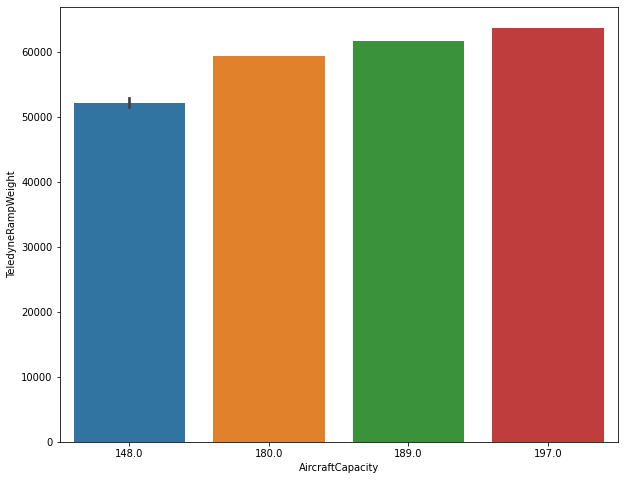

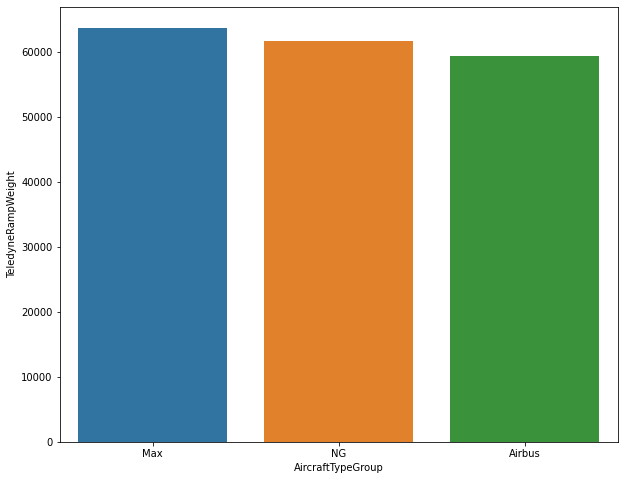

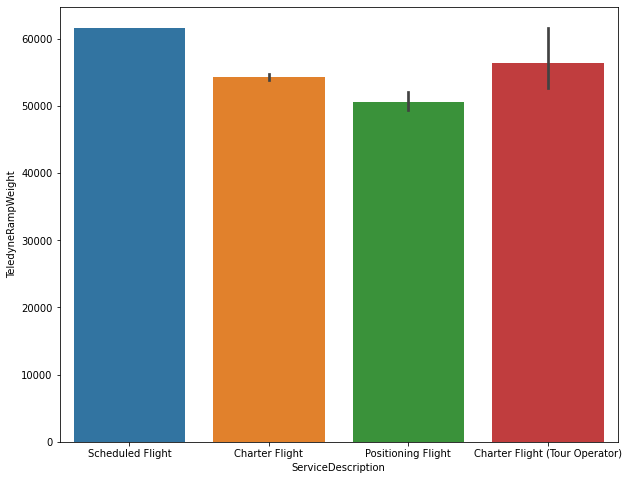

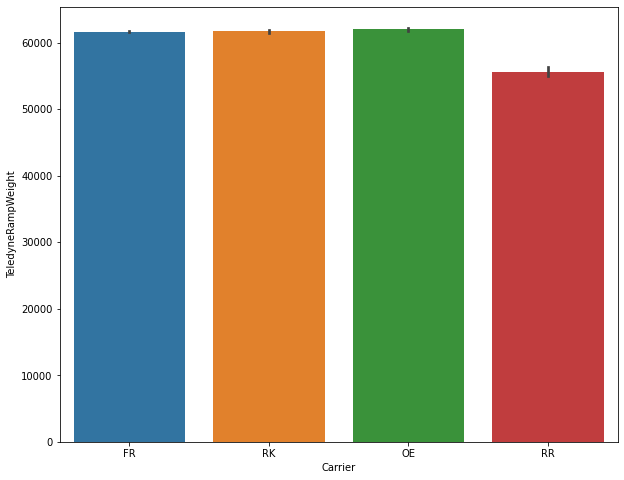

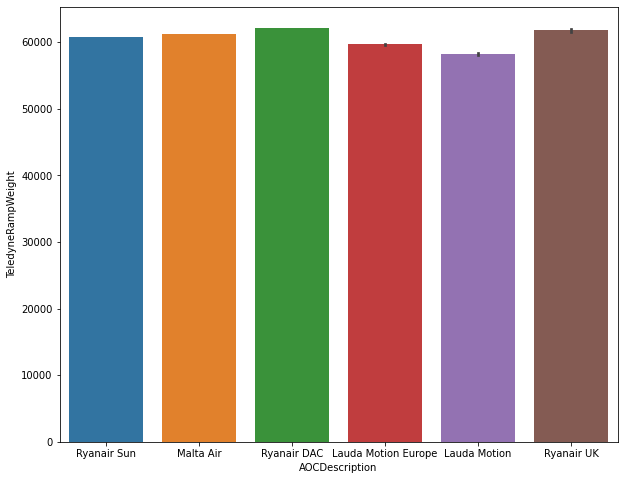

In [11]:
cat_cols = ['AircraftCapacity', 'AircraftTypeGroup', 'ServiceDescription', 'Carrier', 'AOCDescription']

for col in cat_cols: 
    plt.figure(figsize=(10, 8), facecolor="white")
    sns.barplot(x = col, y = "TeledyneRampWeight", data = merged_train)
    plt.show();

In [9]:
cat_cols = ['AircraftCapacity', 'AircraftTypeGroup', 'ServiceDescription', 'Carrier', 'AOCDescription']
merged_train["AircraftCapacity"] = merged_train["AircraftCapacity"].astype(int)

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(merged_train[cat_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(test[cat_cols]))

# Adding the column names for the categorical columns after encoding 
OH_cols_train.columns = OH_encoder.get_feature_names_out()
OH_cols_valid.columns = OH_encoder.get_feature_names_out()

# One-hot encoding removed index; put it back
OH_cols_train.index = merged_train.index
OH_cols_valid.index = test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = merged_train.drop(cat_cols, axis=1)
num_X_valid = test.drop(cat_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X = OH_X_train.drop('TeledyneRampWeight',axis=1)
y = OH_X_train['TeledyneRampWeight']
actual_test = OH_X_valid

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2022)

In [21]:
def run_LR(X_train, X_test, y_train, y_test):
    pipe = make_pipeline(StandardScaler(), LinearRegression())
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f'MAE = {mean_absolute_error(y_pred,y_test)}')
    return pipe

In [22]:
# Iteration 1 - LR with Scaling 
print(f'Train Size = {len(X_train)} Test Size = {len(X_test)}')
run_LR(X_train, X_test, y_train, y_test)

Train Size = 577469 Test Size = 144368
MAE = 998.1238723893016


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [23]:
# Iteration 2 - LR after dropping weight values = 74283 & 55726 (need to decide if this is actual useful. As of now removing it doesn't help) |( y_train == 55726)
rw_indices = y_train[(y_train == 74283)].index
y_train_2 = y_train.drop(rw_indices)
X_train_2 = X_train.drop(rw_indices)
print(f'Train Size = {len(X_train_2)} Test Size = {len(X_test)}')
run_LR(X_train_2, X_test, y_train_2, y_test)

Train Size = 574515 Test Size = 144368
MAE = 984.8604990514935


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [24]:
# Iteration 3 - LR after introducing a column where it tracks if there is no passengers 
X_train_3, X_test_3, y_train_3, y_test_3 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
X_train_3["No_passengers"] = np.where(X_train_3["Adults"] + X_train_3["Children"] + X_train_3["Infants"] == 0, 1,0)
X_test_3["No_passengers"] = np.where(X_test_3["Adults"] + X_test_3["Children"] + X_test_3["Infants"] == 0, 1,0)
print(f'Train Size = {len(X_train_3)} Test Size = {len(X_test_3)}')
run_LR(X_train_3, X_test_3, y_train_3, y_test_3)

Train Size = 577469 Test Size = 144368
MAE = 989.958724605519


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [25]:
# Ieration 4 - LR with no passengers and dropping weight values = 74283
X_train_4, X_test_4, y_train_4, y_test_4 = X_train_2.copy(), X_test.copy(), y_train_2.copy(), y_test.copy()
X_train_4["No_passengers"] = np.where(X_train_4["Adults"] + X_train_4["Children"] + X_train_4["Infants"] == 0, 1,0)
X_test_4["No_passengers"] = np.where(X_test_4["Adults"] + X_test_4["Children"] + X_test_4["Infants"] == 0, 1,0)
print(f'Train Size = {len(X_train_4)} Test Size = {len(X_test_4)}')
pipe_4 = run_LR(X_train_4, X_test_4, y_train_4, y_test_4)

Train Size = 574515 Test Size = 144368
MAE = 976.6861513031348


In [ ]:
iter_train = X_train_4.copy()
iter_train["TeledyneRampWeight"] = y_train_4
iter_test = X_test_4.copy()
iter_test["TeledyneRampWeight"] = y_test_4
actual_test["No_passengers"] = np.where(actual_test["Adults"] + actual_test["Children"] + actual_test["Infants"] == 0, 1,0)
iter_train.to_csv("iter_train.csv", index=False)
iter_test.to_csv("iter_test.csv", index=False)
actual_test.to_csv("actual_test.csv", index=False)

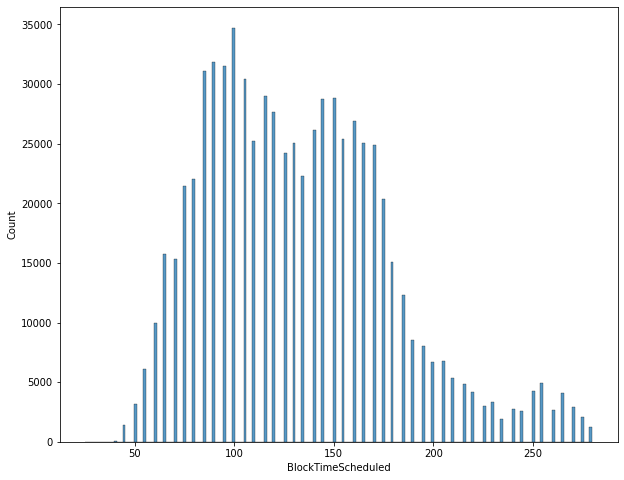

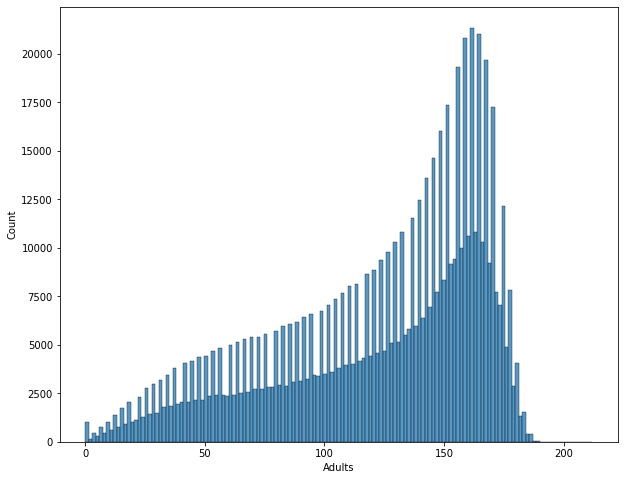

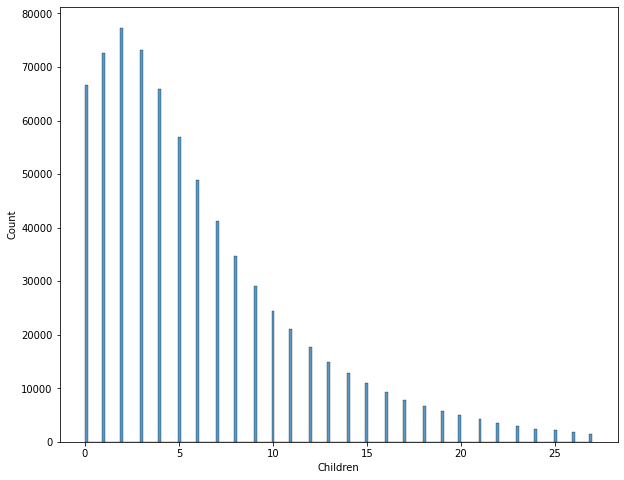

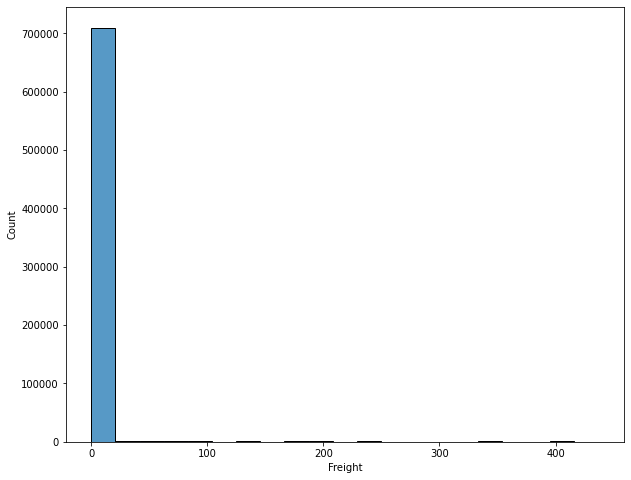

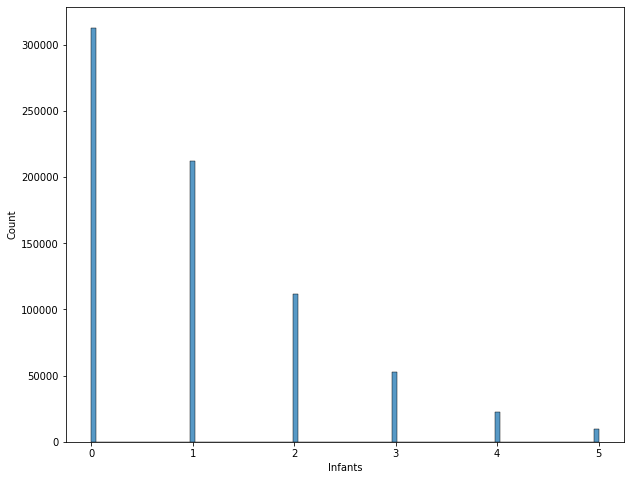

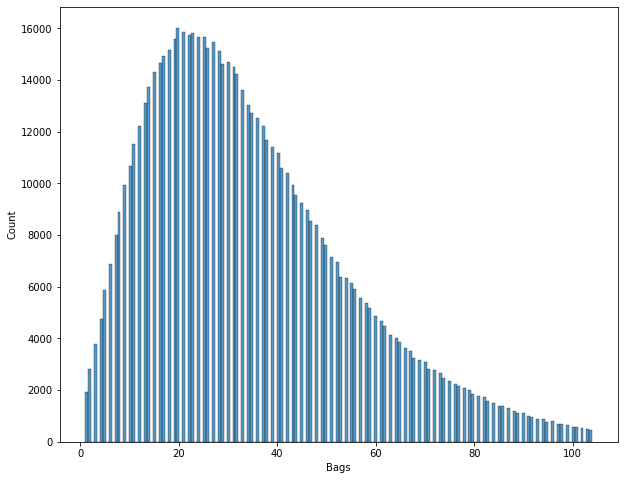

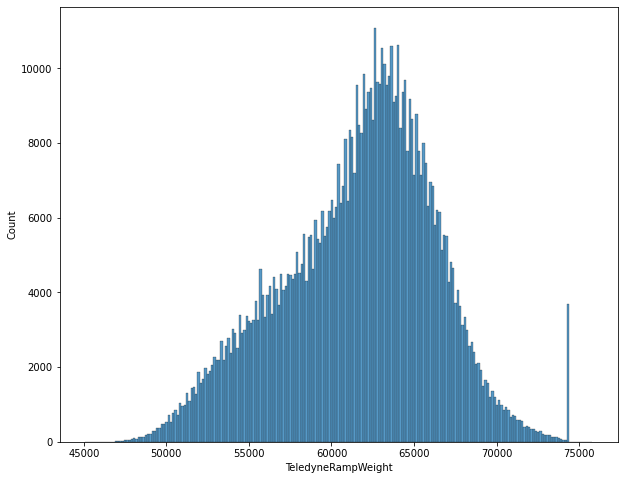

In [57]:
count=1
num_cols = [col for col in train.columns if train[col].dtype != "O"]

for i in num_cols[3:]:
    plt.figure(figsize=(10, 8), facecolor="white")
    sns.histplot(x = i, data = OH_X_train)
    plt.show()

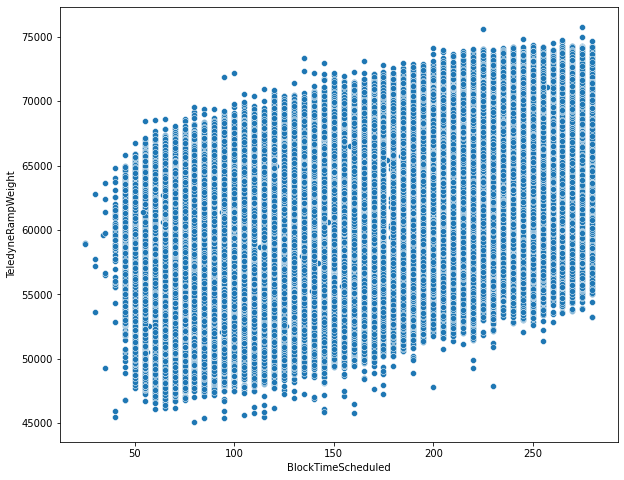

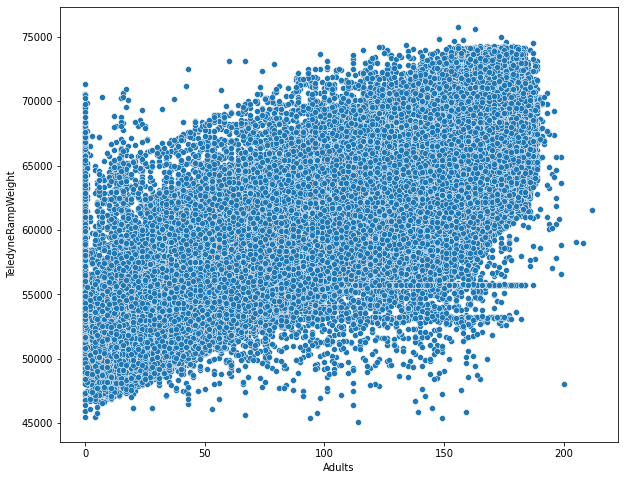

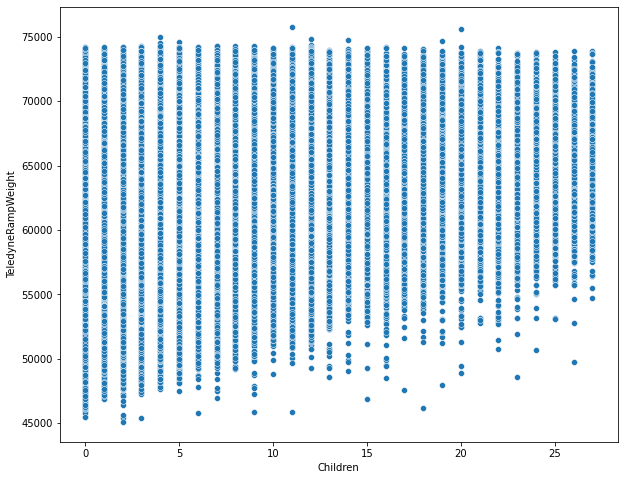

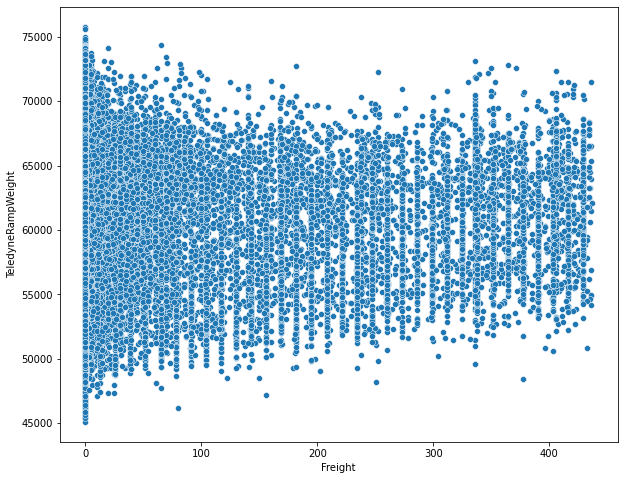

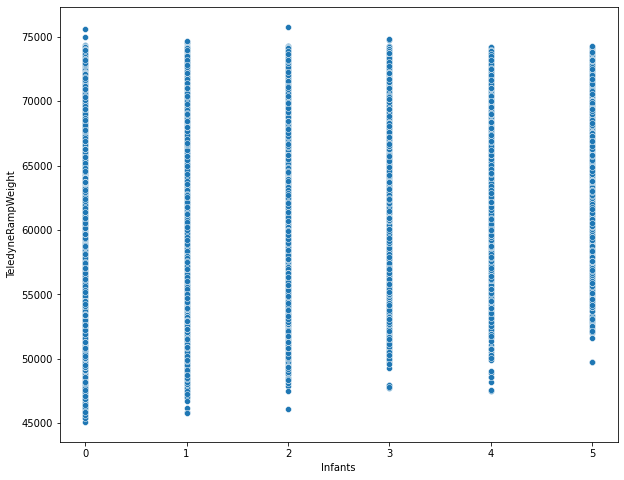

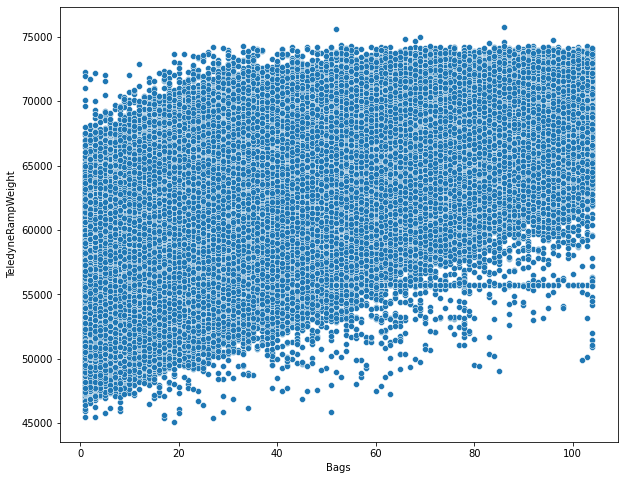

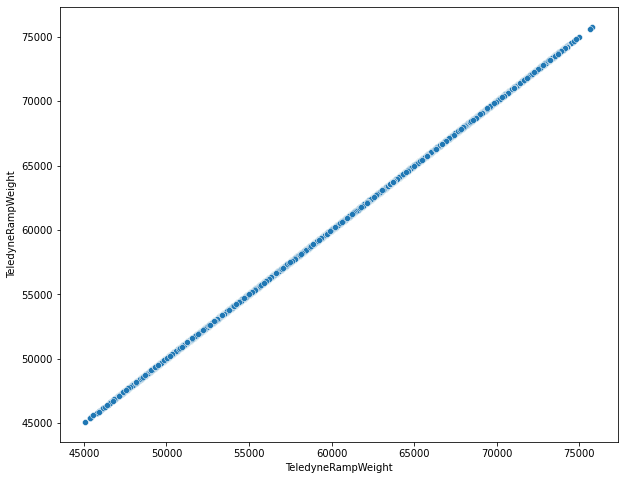

In [88]:
count=1
num_cols = [col for col in train.columns if train[col].dtype != "O"]

for i in num_cols[3:]:
    plt.figure(figsize=(10, 8), facecolor="white")
    sns.scatterplot(x = i, y = "TeledyneRampWeight", data = OH_X_train)
    plt.show()

In [90]:
submission['TeledyneRampWeight'] = iter4_preds
submission.to_csv('LR_iteration4.csv',index=False)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
models = [RandomForestRegressor(), AdaBoostRegressor()]
for model in models: 
    model_name = type(model).__name__
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    submission['TeledyneRampWeight'] = y_pred
    submission.to_csv(f'{model_name}_results.csv',index=False)

### Building a Catboost Model

In [51]:
from sklearn.preprocessing import PowerTransformer
def power_transform(train_data, test_data):
    pt = PowerTransformer(method='yeo-johnson',standardize=False)
    pt_fit = pt.fit_transform(train_data)
    pt_fit_t = pt.transform(test_data)
#     pt_train = pd.DataFrame(pt_fit)
#     pt_test = pd.DataFrame(pt_fit_t)
#     train_data = pd.concat([train_data[['AircraftCapacity','TeledyneRampWeight']],pt_train],axis=1)
#     test_data = pd.concat([test_data['AircraftCapacity'],pt_test],axis=1)
    return pt_fit, pt_fit_t

In [52]:
to_transform = ['BlockTimeScheduled','Adults','Children','Freight','Bags']

X_train_5, X_test_5, y_train_5, y_test_5 = X_train_4.copy(), X_test_4.copy(), y_train_4.copy(), y_test_4.copy()
X_train_5[to_transform], X_test_5[to_transform] = power_transform(X_train_5[to_transform], X_test_5[to_transform])
print(f'Train Size = {len(X_train_5)} Test Size = {len(X_test_5)}')
# run_LR(X_train_5, X_test_5, y_train_5, y_test_5)

Train Size = 143886 Test Size = 578374


In [26]:
num_cols

['FlightID',
 'FlightNumber',
 'AircraftCapacity',
 'BlockTimeScheduled',
 'Adults',
 'Children',
 'Freight',
 'Infants',
 'Bags',
 'TeledyneRampWeight']

In [28]:
X_train_5["Adults"]

165726     252.868593
439601     437.216334
69651     1226.645318
299783    2177.231647
718487     523.717573
             ...     
521143    2177.231647
439985     154.931794
103024     657.243432
147629    1279.935980
349053    2287.707508
Name: Adults, Length: 143613, dtype: float64

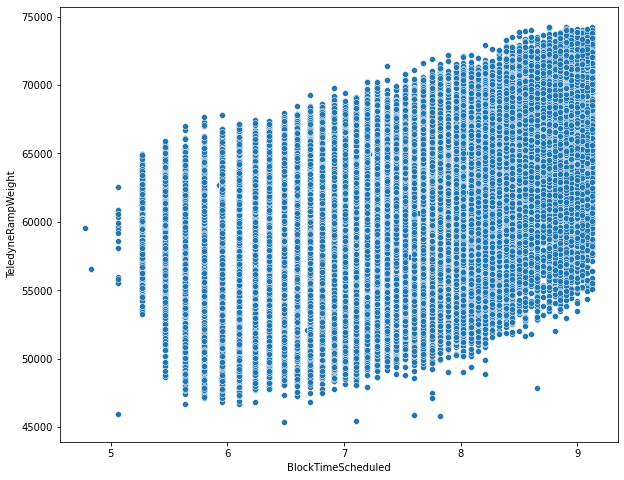

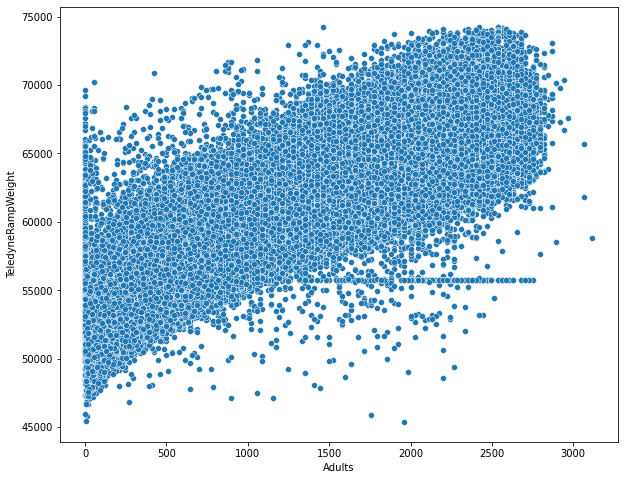

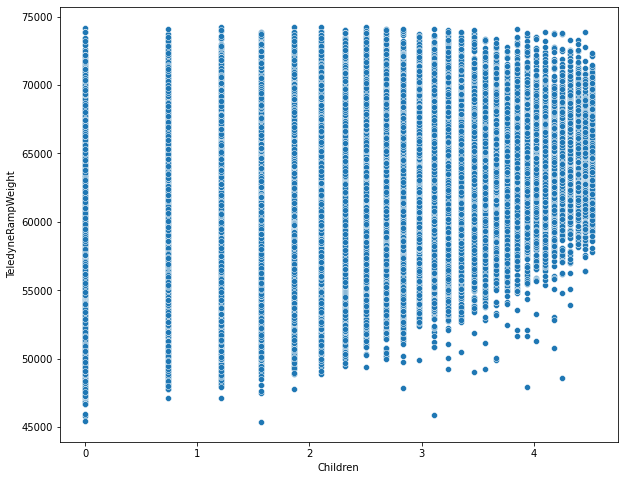

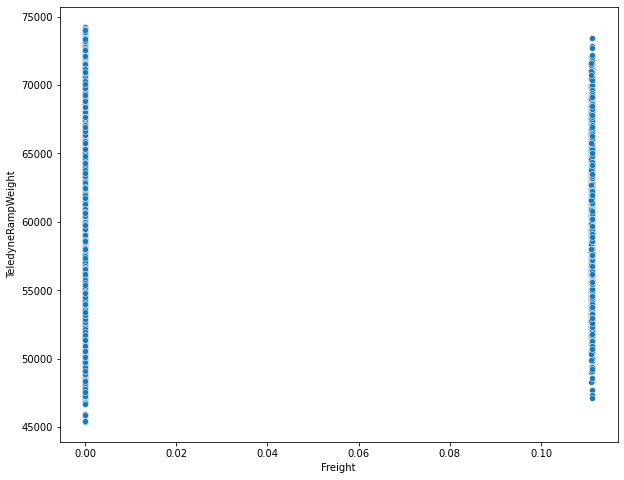

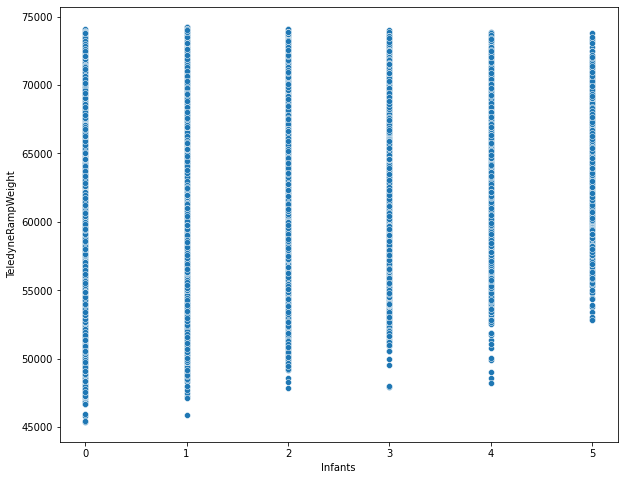

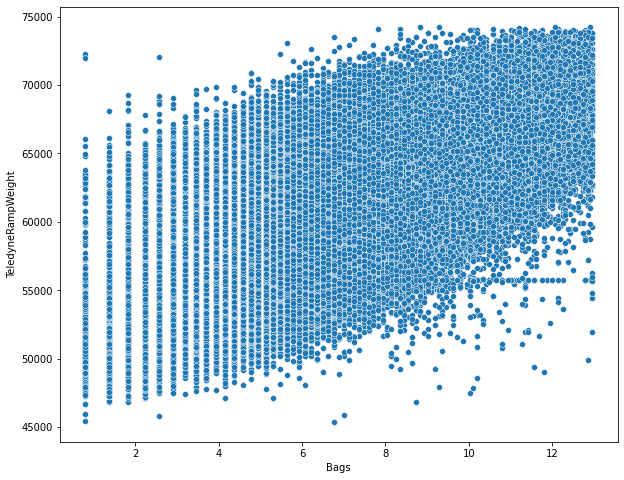

In [29]:
count=1
num_cols = [col for col in train.columns if train[col].dtype != "O"]

for i in num_cols[3:-1]:
    plt.figure(figsize=(10, 8), facecolor="white")
    sns.scatterplot(x = X_train_5[i], y = y_train_5)
    plt.show()

In [16]:
from catboost import CatBoostRegressor

In [26]:
params = {'nan_mode': 'Min', 'eval_metric': 'MAE', 'iterations': 1000,
 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1,
 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum',
 'eval_fraction': 0, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1,
 'boost_from_average': True, 'model_size_reg': 0.5, 'subsample': 0.800000011920929,
 'use_best_model': False, 'random_seed': 154, 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.08902200311422348,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iterations': 1,
 'bootstrap_type': 'MVS', 'max_leaves': 64, 'silent':True}
cat = CatBoostRegressor(silent=True)

In [27]:
cat.fit(X_train_4, y_train_4)
cat_predicts = cat.predict(X_test_4)
print(f'MAE = {mean_absolute_error(cat_predicts, y_test_4)}')

/home/aravi/miniconda3/envs/datawhale/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


MAE = 953.7906074486041


In [179]:
actual_test["No_passengers"] = np.where(actual_test["Adults"] + actual_test["Children"] + actual_test["Infants"] == 0, 1,0)
test_preds = cat.predict(actual_test)
submission['TeledyneRampWeight'] = test_preds
submission.to_csv('catboost_4.csv',index=False)

/home/aravi/miniconda3/envs/datawhale/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [73]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 1.4 MB/s eta 0:00:0000:0100:01


In [17]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [31]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV

from sklearn.pipeline import make_pipeline

ridge_pipe = make_pipeline(StandardScaler(), RidgeCV())


estimators = [
    ("XGB", XGBRegressor(n_estimators = 500)),
    ("Tree", DecisionTreeRegressor()), 
    ("Cat", CatBoostRegressor(silent=True))
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=ridge_pipe)
stacking_regressor

StackingRegressor(estimators=[('XGB',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=Non...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=None, reg_lambda=None, ...)),
                              ('Tree', DecisionTreeRegressor()),
                              ('Cat',
                               <catboost.core.CatBoostRegressor object at 0x7f933cc22fd0>)],
                  final_estimator=Pipeline(steps=[('standardscaler',
                                                   StandardScaler()),
                                                  ('ridgecv', RidgeCV())]))

In [32]:
stacking_regressor.fit(X_train_4, y_train_4)
stack_preds = stacking_regressor.predict(X_test_4)
print(f'MAE = {mean_absolute_error(stack_preds, y_test_4)}')

/home/aravi/miniconda3/envs/datawhale/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/home/aravi/miniconda3/envs/datawhale/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


MAE = 953.6376649548308


/home/aravi/miniconda3/envs/datawhale/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [89]:
actual_test["No_passengers"] = np.where(actual_test["Adults"] + actual_test["Children"] + actual_test["Infants"] == 0, 1,0)
test_preds = stacking_regressor.predict(actual_test)
submission['TeledyneRampWeight'] = test_preds
submission.to_csv('stack_model.csv',index=False)

/home/aravi/miniconda3/envs/datawhale/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
